In [1]:
import tensorflow
import tensorflow as tf
import math
import random
import numpy as np
import threading
import datetime
from collections import deque
import matplotlib.pyplot as plt
import time
import os
import sys
import json
from contextlib import redirect_stdout
import re
sys.path.append('../')
from model_structure import create_my_model


# config

In [2]:
# import pygame
# this is config file:

# Set the maximum amount of movement for the circle
max_movement = 5

#dimention of game window
window_width, window_height = 600, 550

# Set the color of the circle (in RGB format)
circle_color = (255, 0, 0)  # Red

#color of window background
colorOfBackground = (0, 10, 0)

# Set the color of the line (in RGB format)
line_color = (255, 255, 255)  # blue
border_line_color = (80, 50, 80)  # blue
line_thick = 10

# width of line
width_of_lines = 100


distance_from_window = 10

line_start_x_left = distance_from_window
line_end_x_left = distance_from_window
line_start_x_right = window_width - distance_from_window
line_end_x_right = window_width - distance_from_window

radius = 30

# Set the font for the exit button
exit_button_text = "Exit Game"
button_color = (255, 0, 0)
exit_button_text_color = (255, 255, 255)
exit_button_width = 100
exit_button_height = 50
exit_button_x = (window_width - exit_button_width) // 2
exit_button_y = (window_height - exit_button_height) // 2 + 100

# final score of game
finalScore = 10000

# backUp addres
backUpFilePath = "./modelBackUp.h5"

# functions

In [3]:
# check location of circle and if circle recive the edge of screen it allow to change direction of circle
def circleDirection(center_x, center_y):
    condition1 = (center_x > window_width - (radius+distance_from_window+line_thick))
    condition2 = (center_x < (radius+distance_from_window+line_thick))
    condition3 = ((center_y > window_height - (radius+distance_from_window+line_thick)))
    condition4 = ((center_y < (radius+distance_from_window+line_thick)))
    if (condition1 or condition2 or condition3 or condition4):
        movement_flag = True
        # here gameover checked
        # Check location of circle and determine which side it has touched
        if center_x <= radius + distance_from_window + line_thick:
            # Circle touched the left side
            return movement_flag, 'left'

        elif center_x >= window_width - (radius + distance_from_window + line_thick):
            # Circle touched the right side
            return movement_flag, 'right'

        elif center_y <= radius + distance_from_window + line_thick:
            # Circle touched the top side
            return movement_flag, 'top'

        elif center_y >= window_height - (radius + distance_from_window + line_thick):
            # Circle touched the bottom side
            return movement_flag, 'bottom'
    else:
        return False, None #movement_flag, state

def zeroCorr(num, state, epsilon):
    if(num == 0):
        if(state == -1):
            return -epsilon
        else:
            return epsilon
    else:
        return num

# Generate random movement for the circle
def circleMovement(movement_fleg, center_x, center_y, p_center_x, p_center_y, edgeState):
    counter = 1
    epsilon = 0.01
    if movement_fleg:
        while True:
            center_x_test = center_x
            center_y_test = center_y
            if(p_center_x < center_x and p_center_y > center_y):
                if(edgeState == 'top'):
                    movement_x = random.randint(1, max_movement)
                    movement_y = random.randint(1, max_movement)
                else:#right
                    movement_x = random.randint(-max_movement, -1)
                    movement_y = random.randint(-max_movement, -1)
            elif(p_center_x > center_x and p_center_y > center_y):
                if(edgeState == "top"):
                    movement_x = random.randint(-max_movement, -1)
                    movement_y = random.randint(1, max_movement)
                else:#left
                    movement_x = random.randint(1, max_movement)
                    movement_y = random.randint(-max_movement, -1)
            elif(p_center_x > center_x and p_center_y < center_y):
                if(edgeState == 'left'):
                    movement_x = random.randint(1, max_movement)
                    movement_y = random.randint(1, max_movement)
                else:#bottom
                    movement_x = random.randint(-max_movement, -1)
                    movement_y = random.randint(-max_movement, -1)
            elif(p_center_x < center_x and p_center_y < center_y):
                if(edgeState == 'right'):
                    movement_x = random.randint(-max_movement, -1)
                    movement_y = random.randint(1, max_movement)
                else: #bottom
                    movement_x = random.randint(1, max_movement)
                    movement_y = random.randint(-max_movement, -1)
            else:
                movement_x = random.randint(-max_movement, max_movement)
                movement_y = random.randint(-max_movement, max_movement)

            if (counter > 10):
                center_x_test = center_x
                center_y_test = center_y
                if(edgeState == 'top'):
                    # if(p_center_x < center_x and p_center_y > center_y):
                    if(random.randint(0, 1)):
                        movement_x = 1
                        movement_y = 1
                    else:
                        movement_x = -1
                        movement_y = 1
                if(edgeState == 'right'):
                    # if(p_center_x < center_x and p_center_y < center_y):
                    if(random.randint(0, 1)):
                        movement_x = -1
                        movement_y = 1
                    else:
                        movement_x = -1
                        movement_y = -1
                if(edgeState == 'bottom'):
                    # if(p_center_x > center_x and p_center_y < center_y):
                    if(random.randint(0, 1)):
                        movement_x = 1
                        movement_y = -1
                    else:
                        movement_x = -1
                        movement_y = -1
                if(edgeState == 'left'):
                    # if(p_center_x > center_x and p_center_y > center_y):
                    if(random.randint(0, 1)):
                        movement_x = 1
                        movement_y = -1
                    else:
                        movement_x = 1
                        movement_y = 1
                break

            center_x_test += movement_x
            center_y_test += movement_y
            # check next location of circle and if the next locatio is out of screen determine new movement
            condition1 = (center_x_test <= window_width-(radius+distance_from_window+line_thick))
            condition2 = (center_x_test >= (radius+distance_from_window+line_thick))
            condition3 = (center_y_test <= window_height-(radius+distance_from_window+line_thick))
            condition4 = (center_y_test >= (radius+distance_from_window+line_thick))
            # print(counter)
            if(condition1 and condition2 and condition3 and condition4):
                break
            counter +=1
        movement_fleg = False
        return movement_fleg, movement_x, movement_y

def referee(mouse_y, center_y, y_opponent, edgeState):
    quitGame = False
    if(edgeState == 'left'):
        if(mouse_y-(width_of_lines/2)<center_y<mouse_y+(width_of_lines/2)):
            quitGame = False
            return quitGame
        else:
            quitGame = True
            return quitGame
    elif(edgeState == 'right'):
        if (y_opponent - (width_of_lines / 2) < center_y < y_opponent + (width_of_lines / 2)):
            quitGame = False
            return quitGame
        else:
            quitGame = True
            return quitGame
    else:
        quitGame = False
        return quitGame


def update_scores(player1_score, player2_score):
    pass


# reward function
def opponentReward(opponentMovement, y_opponent, circle_y, circleNotStrike, edgeState, faultForMOveToCourner):
    reward = 0 #if controller not moved
    if(opponentMovement != 0):
        reward = -0.5
    if(faultForMOveToCourner == True):
        reward = -10
    if(edgeState == 'right'):
        a = 500
        c = 59.2
        if(circleNotStrike == True):
            reward = (a*np.exp(-((abs(y_opponent-circle_y))**2)/(2*(c**2))))-350
        else:
            reward = ((a * np.exp(-((abs(y_opponent-circle_y))**2) / (2 * (c**2)))) - 350) * 2.3
    # print("reward is: ", reward)
    return float(reward)

# log functions
def log_to_json(log_data, log_filename='log.json'):
    # Check if the log file already exists
    if os.path.exists(log_filename):
        # If it exists, load the existing log data
        with open(log_filename, 'r') as file:
            try:
                existing_data = json.load(file)
            except json.JSONDecodeError:
                existing_data = []

        # Append the new log data to the existing data
        existing_data.append(log_data)
    else:
        # If the log file doesn't exist, create a new log data list
        existing_data = [log_data]

    # Write the combined log data back to the log file
    with open(log_filename, 'w') as file:
        json.dump(existing_data, file, indent=4)


# QValueFunction

In [4]:
class QValueFunction:
    def __init__(self, state_size, action_size, x_min, x_max, initial_learning_rate = 0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model(initial_learning_rate)
        self.x_min = x_min
        self.x_max = x_max

    def build_model(self, initial_learning_rate):
        model = create_my_model(self.state_size, self.action_size)
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def compute_accuracy(self, inputs, targets):
        predicted_probabilities = np.abs(self.model.predict(inputs).reshape(-1))
        targets = np.abs(targets)
        
        max_predicted = np.max(predicted_probabilities)
        max_targets = np.max(targets)


        if max_predicted == 0 or max_targets == 0:
            return 0.0
        
        normalized_predicted = predicted_probabilities / max_predicted
        normalized_targets = targets / max_targets
        if(np.max(normalized_predicted) > 1 or np.max(normalized_targets) > 1 or np.max(normalized_predicted) < -1 or np.max(normalized_targets) < -1):
            print("normalized_predicted", np.max(normalized_predicted), "normalized_targets", np.max(normalized_targets))
        
        accuracy = np.mean(np.abs(normalized_predicted - normalized_targets))
        return (1 - accuracy)


    def train(self, states, actions, targets, numberOfTrain):
        maxEpock = numberOfTrain
        sample_step = 10
        sample_print = 500
        loss_value = float('inf')  # Initialize the loss value to a large number
        epochs = 0
        loss_history = []
        accuracy_history = []
        accuracy_val = 0
        accuracy_threshold = 0.9
        inputs = np.hstack((states, np.expand_dims(actions, axis=-1)))  # Concatenate states and actions
        print("number of data is: ", inputs.shape[0])
        
        if(self.compute_accuracy(inputs, targets) > accuracy_threshold):
            print("accuracy is upper than: ", accuracy_threshold, "it is: ", self.compute_accuracy(inputs, targets))
            return 0
        
        while 1:
            history = self.model.fit(inputs, targets, epochs=1, verbose=0, batch_size=int(inputs.shape[0]/2))
            epochs += 1
            if(epochs%sample_step == 0):
              loss_value = history.history['loss'][-1]
              loss_history.append(loss_value)
              accuracy_val = self.compute_accuracy(inputs, targets)
              accuracy_history.append(accuracy_val)
              if(epochs%sample_print == 0):
                print("accuracy: ", accuracy_val)
                print(f"Epoch: {epochs}, Loss value: {loss_value}")

            if ((epochs > maxEpock) or (accuracy_val > accuracy_threshold)):
              print("accuracy: ", accuracy_val)
              print(f"Epoch: {epochs}, Loss value: {loss_value}")
              break

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(range(1, len(loss_history) + 1), loss_history)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss Value')
        ax1.set_title('Training Loss History')
        ax1.grid(True)

        ax2.plot(range(1, len(accuracy_history) + 1), accuracy_history)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training Accuracy History')
        ax2.grid(True)

        # Create a directory for saving the plots if it doesn't exist
        save_dir = './loss_plots/'
        os.makedirs(save_dir, exist_ok=True)
        # Generate a unique filename using the current timestamp
        timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        file_name = f'loss_curve_{timestamp}.png'
        # Save the plot to the specific directory with the unique filename
        plt.savefig(os.path.join(save_dir, file_name))
        # Close the plot to free up memory
        plt.close()

    def predict(self, states):
        num_actions = self.x_max - self.x_min + 1
        action_values = np.arange(self.x_min, self.x_max + 1)
        states = np.array(states)
        num_states = states.shape[0]
        states = np.hstack((states, np.zeros((num_states, 1), dtype=int)))  # Add a column with zeros
        # Create a state-action matrix with all possible actions for each state
        state_plus_actions = np.repeat(states, num_actions, axis=0)
        action_tile = np.tile(action_values, num_states)
        state_plus_actions[:, -1] = action_tile
        # Predict Q-values for all state-action pairs in parallel
        q_values = self.model.predict(state_plus_actions)
        # Reshape the Q-values to have a separate row for each state
        q_values = q_values.reshape(num_states, num_actions)
        # Find the action corresponding to the minimum Q-value for each state
        min_q_values = np.max(q_values, axis=1)
        return min_q_values




# RLAgent

In [5]:
# Design the RL Agent
class RLAgent:
    def __init__(self, state_size, action_size, x_min, x_max, discount_factor,  buffer_size):
        self.state_size = state_size
        self.action_size = action_size
        self.x_min = x_min
        self.x_max = x_max
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)
        self.discount_factor = discount_factor
        self.model = self.build_model()
        self.backup_model = None  # Initialize the backup model as None

    def build_model(self):
        model = create_my_model(self.state_size, self.action_size)
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def get_action(self, circle_x, circle_y, control_line_y):
        threshold = 0.05
        random_number = random.random()  # Generate a random number between 0 and 1
        action_values = np.arange(self.x_min, self.x_max + 1)
        if random_number > threshold:
            num_actions = self.x_max - self.x_min + 1
            state = np.array([[circle_x, circle_y, control_line_y, 0]])
            # Create a state-action matrix with all possible actions
            state_plus_actions = np.tile(state, (num_actions, 1))
            state_plus_actions[:, -1] = action_values
            # Predict Q-values for all state-action pairs in parallel
            q_values = self.model.predict(state_plus_actions, verbose= -1)
            # Find the action corresponding to the minimum Q-value
            action = action_values[np.argmax(q_values)]
            # print(np.max(q_values))
        else:
            action = random.choice(action_values)
        return action

    def add_experience(self, state, action, reward, next_state):
        experience = (state, action, reward, next_state)
        self.buffer.append(experience)

    def free_up_buffer(self):
        # Reassign the buffer to a new empty deque
        self.buffer = deque(maxlen=self.buffer_size)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        return states, actions, rewards, next_states

    def get_full_batch(self):
        states = np.array([e[0] for e in self.buffer])
        actions = np.array([e[1] for e in self.buffer])
        rewards = np.array([e[2] for e in self.buffer])
        next_states = np.array([e[3] for e in self.buffer])
        return states, actions, rewards, next_states

    def save_backup_model(self, filepath):
        if self.backup_model is not None:
            self.backup_model.save_weights(filepath)

    def load_backup_model(self, filepath):
        # Create a new QValueFunction model
        q_value_model = QValueFunction(self.state_size, self.action_size, self.x_min, self.x_max)
        # Load the model weights from the file
        q_value_model.model.load_weights(filepath)
        self.model = q_value_model.model
        # Set the loaded model as the backup model
        self.backup_model = q_value_model.model
        q_value_model = None

    def train_q_value_function(self, numberOfTrain, initial_learning_rate):
        q_value_model = QValueFunction(self.state_size, self.action_size, self.x_min, self.x_max, initial_learning_rate)
        q_value_model.model = self.model
        # Sample a batch from the replay buffer
        states, actions, rewards, next_states = self.get_full_batch()
        # Compute the target Q-values using the Bellman equation
        target_q_values = rewards + self.discount_factor * q_value_model.predict(next_states)
        # Train the QValueFunction model using the batch
        q_value_model.train(states, actions, target_q_values, numberOfTrain)
        self.model = q_value_model.model
        self.backup_model = q_value_model.model  # Update the backup model with the trained model
        self.save_backup_model(backUpFilePath)
        q_value_model = None

# important variable

In [6]:
# numTrain bufferSize discountFactor numberOfTest TestThreshold initLearningRate
# 7000, 16000, 0.95, 40, 30, 0.01 --> accuracy: 0.5
# 500, 2000, 0.95, 5, 5, 0.01  --> accuracy: 0.7
# 1000, 4000, 0.95, 10, 8, 0.01 --> accuracy: 0.1

numberOftrain = 500
buffer_size = 2500  # Set your preferred buffer size
discount_factor = 0.96
number_of_test_mode_cycle = 20
number_of_ture_prediction_thereshold = 15
initial_learning_rate = 0.01

# train mode

regular mode: 
experiment sample:  1000
regular mode: 
experiment sample:  2000
ball cycle =  9
train model begin
number of data is:  2500
accuracy:  0.7109358439701498
Epoch: 500, Loss value: 265.99676513671875
accuracy:  0.7109358439701498
Epoch: 501, Loss value: 265.99676513671875
test mode runing...
test mode: 
Ball Cycle:  0
test mode: 
Ball Cycle:  10
test mode: 
Ball Cycle:  20
**** new best in reward ****
**** new best in prediction ****
*******************************
*                             *
rate of true prediction:  0.05
sum of reward:  -72392.7385026063
*                             *
*******************************
test mode ended
regular mode: 
experiment sample:  0
regular mode: 
experiment sample:  1000
regular mode: 
experiment sample:  2000
ball cycle =  5
train model begin
number of data is:  2500
accuracy:  0.7214052581425164
Epoch: 500, Loss value: 258.4471435546875
accuracy:  0.7214052581425164
Epoch: 501, Loss value: 258.4471435546875
test mode runing...
t

test mode runing...
test mode: 
Ball Cycle:  0
test mode: 
Ball Cycle:  10
test mode: 
Ball Cycle:  20
*******************************
*                             *
rate of true prediction:  0.55
sum of reward:  -19832.735009709755
*                             *
*******************************
test mode ended
regular mode: 
experiment sample:  0
regular mode: 
experiment sample:  1000
regular mode: 
experiment sample:  2000
ball cycle =  7
train model begin
number of data is:  2500
accuracy:  0.7903269622492628
Epoch: 500, Loss value: 331.3840026855469
accuracy:  0.7903269622492628
Epoch: 501, Loss value: 331.3840026855469
test mode runing...
test mode: 
Ball Cycle:  0
test mode: 
Ball Cycle:  10
test mode: 
Ball Cycle:  20
*******************************
*                             *
rate of true prediction:  0.1
sum of reward:  -45298.53597095495
*                             *
*******************************
test mode ended
regular mode: 
experiment sample:  0
regular mode: 
ex

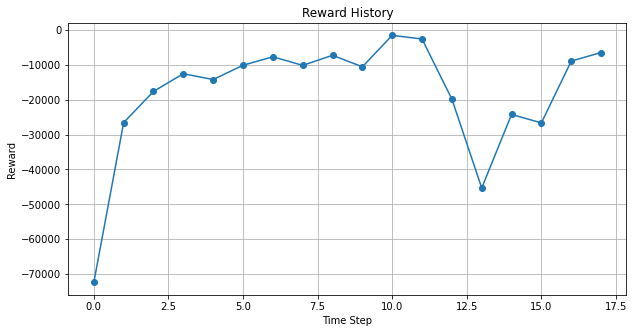

In [7]:
# Set the center coordinates
center_x, center_y = window_width // 2, window_height // 2
p_center_x = center_x
p_center_y = center_y
# y position of opponent plate in game
y_opponent = center_y
# define postoin of circle in window
edgeState = None
# delay of end of every frame to slow down game

# if this flag set to True mean that the direction of circle should be changed
movement_fleg = False
movement_x = 1
movement_y = 1
faultForMOveToCourner = False
# Main game loop
running = True

# score of players in the game
player1_score = 0
player2_score = 0

# control line parameter
# Define the RL Environment
state_size = 3  # Assuming the state is represented by center_y and y_opponent
action_size = 1  # Assuming the action is a single continuous value
action_min_value = -4
action_max_value = 4
# buffer_size = 2000  # Set your preferred buffer size
# discount_factor = 0.95
opponentRl = RLAgent(state_size, action_size, action_min_value, action_max_value, discount_factor, buffer_size)

# model log

log_entry = {
    'time': str(time.time()),
    'number of epoch': str(numberOftrain),
    'buffer size': str(buffer_size),
    'discount factor': str(discount_factor),
    'number of test sample': str(number_of_test_mode_cycle),
    'initial learning rate': str(initial_learning_rate)
}

log_to_json(log_entry)

# Capture the model summary output
with open('model_summary.txt', 'w') as summary_file:
    with redirect_stdout(summary_file):
        opponentRl.model.summary()

# Read the captured model summary and extract "Output Shape" information
with open('model_summary.txt', 'r') as summary_file:
    summary_text = summary_file.read()

# Use regular expressions to extract "(None, XX)" patterns
output_shape_info = re.findall(r'\(None, \d+\)', summary_text)

# Create a log entry with the extracted "Output Shape" information
log_entry = {
    'output_shape_info': output_shape_info
}

# Call the log_to_json function to append the log entry to the log file
log_to_json(log_entry)

# if recently model trained
# if os.path.exists(backUpFilePath):
#     opponentRl.load_backup_model(backUpFilePath)

reward = 0

howManyTimeLearnCyckeHappen = 1

howManySampleInBuffer = buffer_size  # depend on buffer
howManySampleInBuffer_counter = 0

predictActionNumber = 4
predictActionNumber_counter = 0
y_opponent_movement = 0

load_backUp_counter = 0
load_backUp_threshold = 2

number_of_true_prediction = 0
number_of_true_prediction_old = 0
# number_of_test_mode_cycle = 5
# number_of_ture_prediction_thereshold = 5
testMode = False


sum_of_reward = 0
sum_of_reward_best = -100000

initial_learning_rate_counter = 0
initial_learning_rate_threshold = 5

reward_history = []


while running:
    # Generate random movement for the circle
    if movement_fleg:
        movement_fleg, movement_x, movement_y = circleMovement(movement_fleg, center_x, center_y, p_center_x, p_center_y, edgeState)

    # Update the center coordinates of the circle
    p_center_x = center_x
    p_center_y = center_y
    center_x += movement_x
    center_y += movement_y

    # check location of circle and if circle recive the edge of screen it allow to change direction of circle
    movement_fleg, edgeState = circleDirection(center_x, center_y)

    mouse_y = 0  # this value just for referee function

    # opponent action
    if predictActionNumber_counter == predictActionNumber:
        y_opponent_movement = opponentRl.get_action(center_x, center_y, y_opponent)
        predictActionNumber_counter = 0
    predictActionNumber_counter += 1

    y_old_state = y_opponent  # this variable used in add_experiment function of RLAgent class
    if (((y_opponent + y_opponent_movement) <= (window_height - (width_of_lines / 2))) and ((y_opponent + y_opponent_movement) >= (width_of_lines / 2))):
        y_opponent += y_opponent_movement
        faultForMOveToCourner = False
    else:
        faultForMOveToCourner = True


    # referee part
    quitGame = referee(mouse_y, center_y, y_opponent, edgeState)

    if (not quitGame):
        if (edgeState == 'left'):
            player1_score += 1
        elif (edgeState == 'right'):
            player2_score += 1
            if (testMode):
                number_of_true_prediction += 1

    # reward function for take reward to action of opponent movement in game
    reward = opponentReward(y_opponent_movement, y_opponent, center_y, quitGame, edgeState, faultForMOveToCourner)

    if (not testMode):
        # create train dataset to train model for y_controller of opponent player, (s, a, R(s), s')
        opponentRl.add_experience((p_center_x, p_center_y, y_old_state), y_opponent_movement, reward, (center_x, center_y, y_opponent))
        howManySampleInBuffer_counter += 1

    if (not testMode):
        if howManySampleInBuffer_counter == (howManySampleInBuffer):
            print("ball cycle = ", howManyTimeLearnCyckeHappen)
            howManyTimeLearnCyckeHappen = -1
            howManySampleInBuffer_counter = 0
            print("train model begin")

            if(initial_learning_rate_counter == initial_learning_rate_threshold):
                initial_learning_rate /= 5
                initial_learning_rate_counter = 0
            initial_learning_rate_counter += 1

            opponentRl.train_q_value_function(numberOftrain, initial_learning_rate)
            opponentRl.free_up_buffer()
            testMode = True
            print("test mode runing...")
    # test mode:
    else:
        sum_of_reward += reward
        if howManyTimeLearnCyckeHappen == (number_of_test_mode_cycle):
            howManyTimeLearnCyckeHappen = -1
            if (sum_of_reward > sum_of_reward_best):
                opponentRl.save_backup_model("./modelBackUp_best_inReward.h5")
                sum_of_reward_best = sum_of_reward
                load_backUp_counter = 0
                print("**** new best in reward ****")
                log_to_json("new best in reward")
#             else:
#                 if os.path.exists("./modelBackUp_best_inReward.h5" and (load_backUp_counter < load_backUp_threshold)):
#                     opponentRl.load_backup_model("./modelBackUp_best_inReward.h5")
#                     load_backUp_counter += 1

            if (number_of_true_prediction > number_of_true_prediction_old):
                opponentRl.save_backup_model("./modelBackUp_best_inPrediction.h5")
                number_of_true_prediction_old = number_of_true_prediction
                log_to_json("**new_max_prediction**")
                print("**** new best in prediction ****")
            if (number_of_true_prediction >= number_of_ture_prediction_thereshold):
                print("you have good model!")
                print("rate of true prediction: ", number_of_true_prediction/number_of_test_mode_cycle)
                print("sum of reward: ", sum_of_reward)
                log_to_json("rate: "+str(number_of_true_prediction/number_of_test_mode_cycle))
                log_to_json("reward: "+str(sum_of_reward))
                break
            else:
                testMode = False
                howManyTimeLearnCyckeHappen = -1
                print("*******************************")
                print("*                             *")
                print("rate of true prediction: ", number_of_true_prediction/number_of_test_mode_cycle)
                print("sum of reward: ", sum_of_reward)
                print("*                             *")
                print("*******************************")
                log_to_json("rate: "+str(number_of_true_prediction/number_of_test_mode_cycle))
                log_to_json("reward: "+str(sum_of_reward))
                log_to_json("------------")
                reward_history.append(sum_of_reward)
                number_of_true_prediction = 0
                sum_of_reward = 0
                print("test mode ended")

    if (edgeState == 'right'):
        howManyTimeLearnCyckeHappen += 1

    if (testMode):
        if (edgeState == 'right'):
            if (howManyTimeLearnCyckeHappen % 10 == 0):
                print("test mode: ")
                print("Ball Cycle: ", howManyTimeLearnCyckeHappen)
    else:
        if (howManySampleInBuffer_counter % 1000 == 0):
            print("regular mode: ")
            print("experiment sample: ", howManySampleInBuffer_counter)


plt.figure(figsize=(10, 5))
plt.plot(reward_history, marker='o', linestyle='-')
plt.title('Reward History')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()
save_dir = './reward_history/'
os.makedirs(save_dir, exist_ok=True)
# Generate a unique filename using the current timestamp
timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
file_name = f'reward_history_{timestamp}.png'
# Save the plot to the specific directory with the unique filename
plt.savefig(os.path.join(save_dir, file_name))
# Close the plot to free up memory
plt.close()
